# Particle Filter (PF) Demo

Demonstrates Particle Filter with non-linear Range-Bearing tracking:
- Linear motion (constant velocity)
- Non-linear observations (range/bearing in polar coordinates)

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from pf import ParticleFilter
import utils
import warnings
warnings.filterwarnings('ignore')

tfd = tfp.distributions
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Probability version: {tfp.__version__}")

2025-11-23 21:34:26.830810: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2
TensorFlow Probability version: 0.24.0


## 1. Generate Data

In [2]:
# Create model and generate trajectory
dt = 1.0
model = utils.create_model(
    dt=dt, 
    process_noise_std_pos=0.1, 
    process_noise_std_vel=0.1,
    range_noise_std=50.0, 
    bearing_noise_std=0.005, 
    seed=42
)

T = 100
true_states, obs = utils.generate_trajectory(model, T=T)

print(f"Generated {T} observations")
print(f"True states: {true_states.shape}, Observations: {obs.shape}")

Generated 100 observations
True states: (4, 101), Observations: (2, 100)


## 2. Define Functions for Particle Filter

In [3]:
# Get PF-specific functions from utils
true_states = tf.cast(true_states, tf.float64)
x0 = true_states[:, 0]
Sigma0 = tf.eye(4, dtype=tf.float64)

pf_fns = utils.create_pf_functions(model, x0, Sigma0, dtype=tf.float64)

print("Functions defined for Particle Filter")

Functions defined for Particle Filter


## 3. Initialize and Run Particle Filter

In [4]:
true_states = tf.cast(true_states, tf.float64)
x0 = true_states[:,0]
Sigma0 = tf.eye(4, dtype=tf.float64)

In [5]:
# Initialize Particle Filter using functions from utils
pf = ParticleFilter(
    state_transition_fn=pf_fns['state_transition_fn'],
    observation_fn=pf_fns['observation_fn'],
    process_noise_sampler=pf_fns['process_noise_sampler'],
    observation_likelihood_fn=pf_fns['observation_likelihood_fn'],
    x0_sampler=pf_fns['x0_sampler'],
    num_particles=100,
    resample_method='multinomial',
    dtype=tf.float64
)

In [6]:
# Run filter with detailed tracking for degeneracy analysis
obs_float64 = tf.cast(obs, tf.float64)
results = pf.filter(obs_float64, return_details=True)
filtered_states, predicted_states, particles_history, weights_history, ess_history, ancestry_history = results

print(f"Filtered states: {filtered_states.shape}")
print(f"Predicted states: {predicted_states.shape}")
print(f"Particles history: {particles_history.shape}")
print(f"Weights history: {weights_history.shape}")
print(f"ESS history: {ess_history.shape}")

Filtered states: (4, 101)
Predicted states: (4, 100)
Particles history: (4, 100, 101)
Weights history: (100, 101)
ESS history: (101,)


## 4. Evaluate Performance

In [7]:
# Compute performance metrics for both predicted and filtered states
pos_error_filtered = utils.compute_position_error(filtered_states, true_states, exclude_first=True)
pos_error_predicted = utils.compute_position_error(
    tf.concat([true_states[:, 0:1], predicted_states], axis=1), 
    true_states, 
    exclude_first=True
)

rmse_filtered = tf.sqrt(tf.reduce_mean(pos_error_filtered**2))
rmse_predicted = tf.sqrt(tf.reduce_mean(pos_error_predicted**2))

print("\nPerformance (Position RMSE):")
print(f"  Predicted: {rmse_predicted.numpy():.2f}")
print(f"  Filtered:  {rmse_filtered.numpy():.2f}")
print(f"  Improvement: {(1 - rmse_filtered/rmse_predicted)*100:.1f}%")


Performance (Position RMSE):
  Predicted: 20.39
  Filtered:  19.78
  Improvement: 3.0%


## 5. Visualize Results

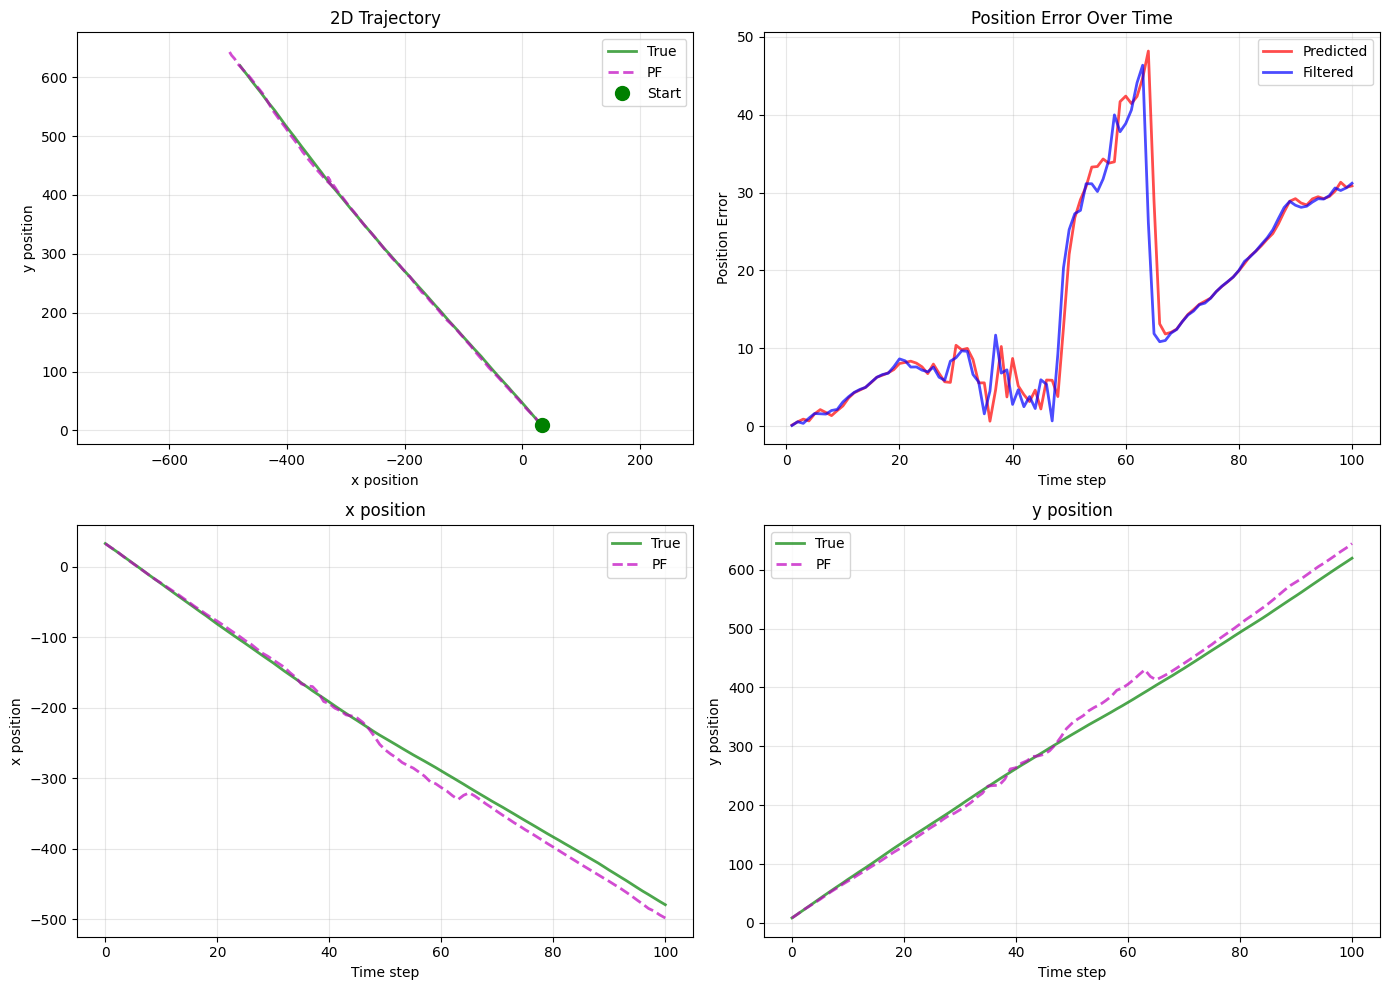

In [8]:
# Plot full comparison using utils
true_np = true_states.numpy()
filtered_np = filtered_states.numpy()

# Create plots showing both predicted and filtered errors
filtered_dict = {'PF': filtered_np}
error_dict = {
    'Predicted': pos_error_predicted.numpy(),
    'Filtered': pos_error_filtered.numpy()
}

fig = utils.plot_full_comparison(true_np, filtered_dict, error_dict)
plt.show()

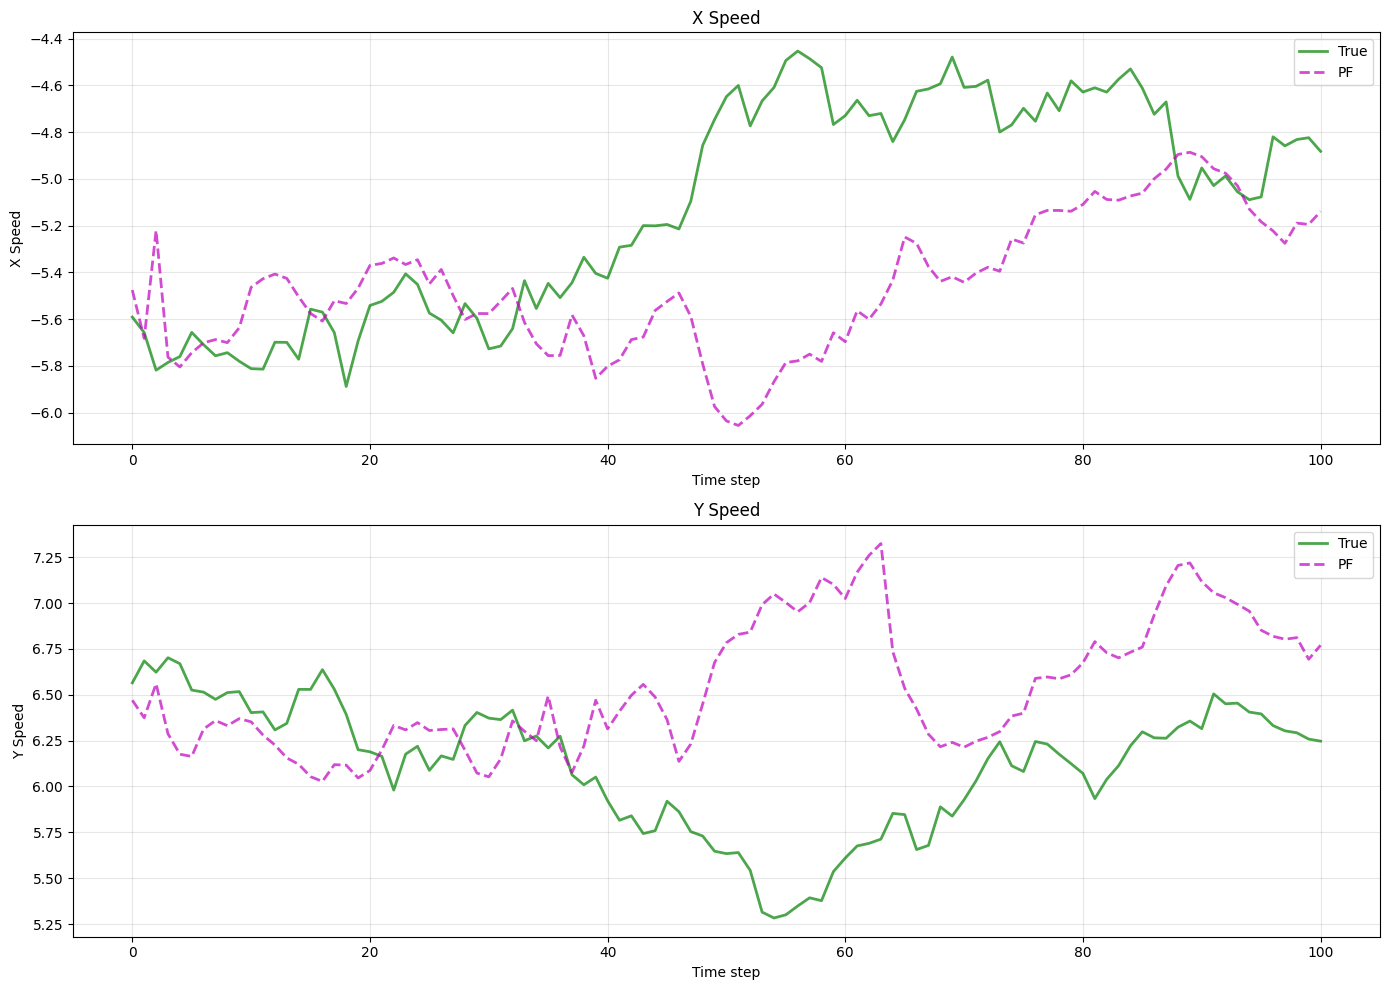

In [9]:
# Plot velocity comparison using utils
fig = utils.plot_velocity_comparison(true_np, filtered_dict)
plt.show()

## 6. Visualize Particle Degeneracy

Particle degeneracy occurs when most particle weights become negligible, leaving only a few particles with significant weights. This is monitored using:
- path_degeneracy

In [10]:
# Use compute_path_degeneracy from utils
# (Function is already defined in utils.py)

In [11]:
num_unique_ancestors = utils.compute_path_degeneracy(ancestry_history)
print("Number of unique ancestors over time:", num_unique_ancestors.numpy())

Number of unique ancestors over time: [  1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   2.   4.   4.   4.   4.   4.   4.   4.   4.   4.   5.   5.   5.
   5.   5.   6.   6.   7.   8.   9.  11.  12.  15.  17.  20.  23.  29.
  40.  58. 100.]


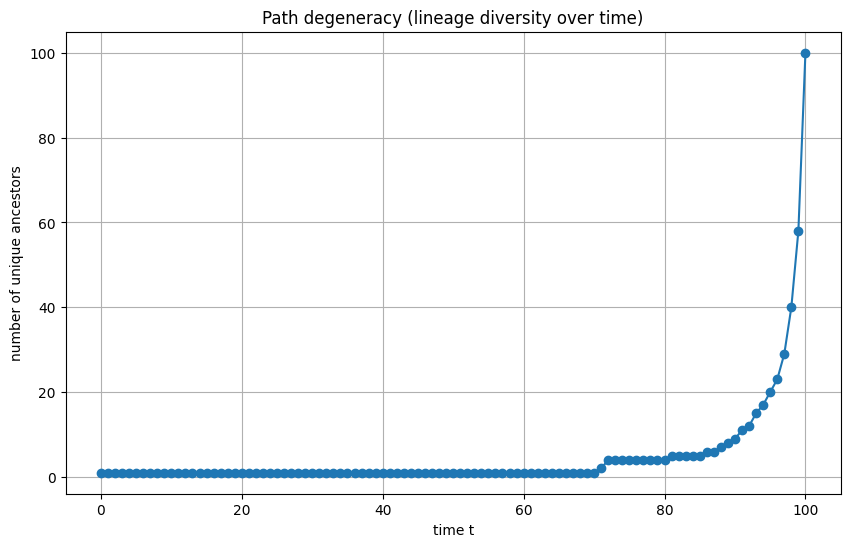

In [12]:
# Plot path degeneracy using utils
utils.plot_pf_degeneracy(num_unique_ancestors.numpy())
plt.show()